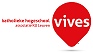<br>


**INTRODUCTION TO ARTIFICIAL INTELLIGENCE**<br>
Academiejaar 2024-2025<br>
Stefaan Haspeslagh<br>
Andy Louwyck

---



---



# Maze

## Inleiding

Het doolhofprobleem is een veel gebruikt probleem om zoekalgoritmen op uit te testen. In deze oefening stellen we een doolhof voor als een rooster met n rijen en n kolommen. We hebben in totaal dus n x n vakken. Een vak kan een barrière bevatten, dit zijn vakjes waarop niet kan 'gewandeld' worden.

De uitdaging is om, gegeven een startpositie (links onder in het voorbeeld), een pad naar het doel te vinden (rechts boven in het voorbeeld). De mogelijke richtingen waarin gewandeld kan worden (in die volgorde!) zijn: links, rechts, naar boven en naar onder. Diagonaal kan er niet gewandeld worden. Dit zijn hier onze **production rules**, die we gaan toepassen op onze huidige toestand of **state** om te weten welke vakjes we in een volgende stap kunnen nemen. Om die volgende zetten of **moves** te kunnen bepalen, moeten we naast de production rules de volgende zaken kennen:

- de *positie* wat het vakje is waar we staan;
- de *configuratie* van het doolhof;
- het *pad* dat we al hebben afgelegd.

Het eerste punt is evident, het tweede is nodig omdat we moeten weten waar de barrières en randen zijn, en het laatste punt is nodig omdat we niet op onze stappen willen terugkeren. Als we alle mogelijke moves hebben berekend, dan kiezen we er één uit en gaan zo één vakje verder, waardoor we in een nieuwe toestand komen. De keuze van die move hangt af van het zoekalgoritme dat we gaan toepassen. Daar gaan we in de volgende topics dieper op in gaan. In deze notebook maken we een implementatie van de **state-space** en de production rules voor het doolhofprobleem. De state-space is de verzameling van alle mogelijke toestanden van het zoekprobleem.

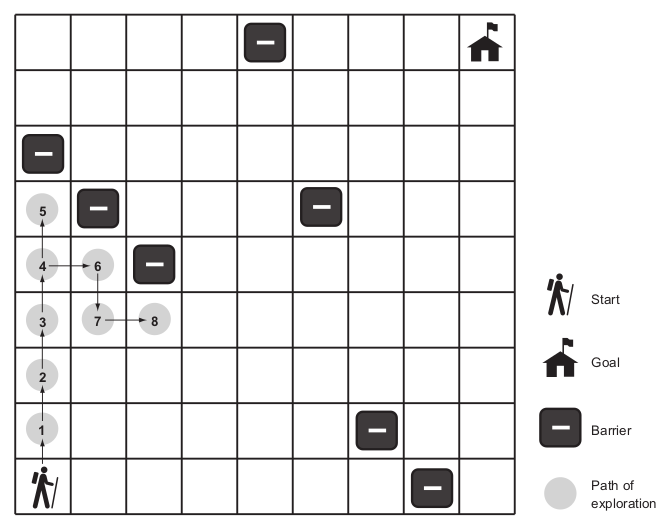

## State-space OO-model

We implementeren een generiek OO-model waarin de volgende concepten van de state-space representation een plaats krijgen:

**state**

Houdt specifieke informatie omtrent de toestand van een zoekprobleem bij. We modelleren dit als een abstracte klasse `State`. Objecten van dit type stellen dan verschillende toestanden van het probleem voor. Voor elk nieuw zoekprobleem zal je een nieuwe klasse moeten ontwerpen die overerft van deze abstracte klasse. Op een state worden de production rules toegepast waaruit dan één move wordt geselecteerd die wordt toegepast op de state om in een nieuwe state te komen.

**goal**

Van elke toestand moeten we kunnen evalueren of dit de doeltoestand van het probleem is. We voorzien hiervoor een functie `is_goal()` in de generieke klasse `State`.

**production rule**

De production rules beschrijven welke 'acties' er kunnen uitgevoerd worden vanuit een state. De production rules formuleren dit eenduidig onafhankelijk van de state. Bijvoorbeeld: vanuit een willekeurig vakje zijn de mogelijke acties een stap naar links, naar rechts, naar boven of naar onder. We maken voor dit concept een klasse `ProductionRule` aan. Concrete rules voor een specifiek probleem moeten hiervan overerven. Het toepassen van een *rule* op een *state* wordt voorgesteld door de functie `apply(self, state) -> Move` en resulteert in een `Move`.

**move**

Een move is zoals hierboven aangehaald een concrete verandering van een welgedefinieerde toestand naar een nieuwe toestand. Dit concept wordt voorgesteld door een klasse `Move`. Een move is één van de production rules die wordt toegepast op een gegeven state. Klasse `Move` krijgt daarom bij instantiatie een welbepaald `State` object en een `ProductionRule` object mee. Een move kan soms niet geldig zijn; dit wordt gecheckt met de methode `is_valid`. Denk aan het doolhofprobleem: als je bijv. in de linkerkolom staat, dan kan je niet naar links bewegen. Met de functie `apply()` pas je de `rule` toe op de `state` en krijg je de nieuwe toestand, een nieuw `State` object dus. Zoals je gezien hebt in de theorie kan er een kost verbonden zijn aan het veranderen van de toestand. Die `cost` modelleren we nu al. Bij *blind search* is deze kost nog niet relevant, in verdere topics zal die wel gebruikt worden.

**path**

Een pad, gemodelleerd met de klasse `Path`, is een opeenvolging van toestanden, die begint bij de initiële toestand, en hopelijk eindigt in de doeltoestand (goal). Daarom moet je op een pad de functie `reaches_goal()` kunnen oproepen die controleert of een pad eindigt in de goal. Paden moeten ook kunnen gecontroleerd worden op *loops* met de methode `has_loop()`. Vanuit een bepaald pad moet je alle kinderen kunnen oproepen. De kinderen van een pad bekom je door het pad uit te breiden met alle mogelijke afstammelingen van de laatste toestand op het pad. Dit is geïmplementeerd in de methode `calculate_children()`. Let op: bij het berekenen van de kinderen zijn loops toegelaten! Verder heeft elke pad een lengte (property `length`): dit is het aantal toestanden (knopen) op het pad. De methode `add(self, state)` is een hulpmethode om een pad uit te breiden naar een nieuwe toestand en dus een nieuw pad te maken.

De OO-structuur biedt een generiek kader waarin we verschillende zoekproblemen kunnen formuleren. In commentaar wordt meer info gegeven over de ontwerpbeslissingen in dit model.

In [ ]:
# eerst importeren we de nodige Python packages, modules, klassen en functies
from abc import ABC, abstractmethod

In [ ]:
# superklasse Move
class Move:
    
    def __init__(self, state, rule, cost=1):
        # state is een State object
        # rule is een ProductionRule object
        self.state = state
        self.rule = rule
        self.cost = cost
    
    def is_valid(self):
        # Checkt of de Move self geldig is.
        # Retourneert True of False.
        return self.state.is_valid_move(self)
    
    def apply(self):
        # Past Move self toe op toestand state en geeft een nieuw State object terug
        return self.state.apply_move(self)

In [ ]:
# superklasse ProductionRule
class ProductionRule:
    
    def apply(self, state) -> Move:
        # methode die een Move object teruggeeft om ProductionRule self op self.state toe te kunnen passen
        return Move(state, self)

In [ ]:
# abstracte superklasse State
class State(ABC):

    rules = []  # list met ProductionRule objecten
    
    def apply_production_rules(self):
        # Op een state wordt deze methode aangeroepen met de production rules om
        # de moves te berekenen die het probleem in een nieuwe toestand kunnen brengen.
        # Deze functie geeft dus een lijst van moves terug.
        return [rule.apply(self) for rule in self.rules]

    @abstractmethod
    def is_valid_move(self, move):
        # Het toepassen van een move op een state kan leiden tot een ongeldige toestand.
        # Deze functie controleert of een state al dan niet een geldige toestand van het probleem is.
        # Retourneert dus een boolean.
        pass
    
    @abstractmethod
    def apply_move(self, move):
        # Op een state kan een move toegepast worden om naar een volgende state over te gaan.
        # Deze functie geeft dus een nieuwe state terug.
        pass
    
    @abstractmethod
    def is_goal(self):
        # Controleert of een state de `goal state` is.
        # Retourneert dus een booleaanse waarde.
        pass
    
    @abstractmethod
    def __eq__(self, other):
        # Vergelijkt toestand self met een andere toestand other
        # nodig om te checken of er al dan niet loops zijn in een pad
        pass

In [ ]:
# superklasse Path
class Path:
    
    def __init__(self, *states, cost=0):
        self.cost = cost # geaccumuleerd cost bijhouden
        self.states = states # een path is een opeenvolging van toestanden
    
    @property
    def length(self):
        # Geeft de lengte van het pad terug, dit is het aantal knopen op het pad,
        # dus het aantal toestanden dat bereikt worden op het pad
        return len(self.states)
    
    def has_loop(self):
        # Een pad bevat een 'loop' indien er twee toestanden op het pad gelijk zijn aan elkaar
        # aangezien de zoekalgoritmen telkens 'loops' verwijderen uit de queue
        # kan er enkel een loop ontstaan indien het pad uitgebreid wordt,
        # dus volstaat het enkel de laatst toegevoegde toestand op het pad te vergelijken met de voorgaande.
        return any([self.states[-1] == other for other in self.states[:-1]])
    
    def contains_state(self, state):
        # controleert of een pad langs een bepaalde toestand 'passeert'
        return state in self.states

    def reaches_goal(self):
        # Controleert of het pad naar de goaltoestand leidt.
        # Roept dus de methode is_goal() op de laatste toestand op het pad op.
        return self.states[-1].is_goal()

    def calculate_children(self):
        # Activeert de "production rules" op de laatste state, om nieuwe afstammelingen (descendants)
        # te genereren. De paden naar die nieuwe descendants zijn de kinderen van het huidige pad (self).
        # Let op! Die paden kunnen loops bevatten!
        moves = self.states[-1].apply_production_rules()
        return [self.__extend(move.apply(), move.cost) for move in moves if move.is_valid()]
    
    def last_state(self):
        return self.states[-1]
    
    def __extend(self, state, cost):
        # Voegt een toestand toe aan het huidige pad.
        # Geeft dus een nieuw pad terug, dat leidt tot de opgegeven toestand.
        return Path(*self.states, state, cost=self.cost+cost)
    
    def __repr__(self):
        # Een pad is een opeenvolging van states.
        # De generieke string-voorstelling van een pad is dus de string-voorstelling van die states.
        states = ", ".join([str(state) for state in self.states])
        return f"[{states}]"

## Maze state-space representation

We kunnen nu ons specifieke doolhofprobleem implementeren door specifieke subklassen te definiëren die erven van de superklassen uit het generieke OO-model dat we hierboven hebben geïmplementeerd.

Aan de hand van de *positie* (`Position`), wat het vakje is waar we staan, en de *configuratie* van het doolhof (`Maze`) definiëren we een specifiek **move** in het doolhof m.b.v. klasse `MazeMove` die erft van `Move`. 

Om vanuit een *state* verschillende *moves* te genereren implementeren we de **production rules** m.b.v. klassen die erven van `ProductionRule`:
- `Left`
- `Right`
- `Up`
- `Down`

De uiteindelijke klasse `MazeState` implementeert dan de **state** m.b.v. alle voorgaande klasses. De **state** wordt gedefinieerd a.d.h.v. een positie in het doolhof, vandaar dat klasse `MazeState` attributen `position` en `maze` bevat. Klasse `MazeState` erft van `State` en moet alle abstracte methoden implementeren. 

In [ ]:
# eerst importeren we de nodige Python packages, modules, klassen en functies
from IPython.display import clear_output
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

## Positie

In het doolhof moeten we dus eerst en vooral de verschillende vakjes of posities kunnen aanduiden. Daarvoor definiëren we een klasse `Position` die een (irow, icol)-coördinaat in het doolhof voorstelt. De coördinaat links boven is (0, 0).

In [ ]:
# klasse Position
class Position:
  
    def __init__(self, irow, icol):
        # Een positie definiëren we adhv rij index irow en kolom index icol van het vakje
        self.irow = irow
        self.icol = icol

    def __eq__(self, other):
        # Twee posities zijn hetzelfde als hun rij en kolom indices gelijk zijn
        return self.irow == other.irow and self.icol == other.icol
    
    def __repr__(self):
        # String voorstelling van de positie: (irow, icol)
        return "({}, {})".format(self.irow, self.icol)

Methode `__init__` kunnen we zien als de constructor van de klasse (ook al is het in principe geen echte constructor). We willen ook nagaan of twee posities al dan niet gelijk zijn, en daarom overschrijven we de "equality" methode `__eq__`, die de gelijkheidsoperator `==` overschrijft. Deze methode retourneert `True` als de coördinaten van twee posities gelijk zijn, en `False` als dat niet zo is. Methode `__repr__` is de methode die een object van die klasse als string weergeeft. We overschrijven ook die methode zodat de coördinaat wordt weergegeven. 

Stel nu dat we de positie op het vakje in rij 1 en kolom 2 willen opslaan, dan instantiëren we een `Position` object met coördinaten `irow=1` en `icol=2`. We kennen het object toe aan variabele `p1`:

In [ ]:
p1 = Position(irow=1, icol=2) # parameternamen irow en icol mag je weglaten als de juiste volgorde wordt gerespecteerd
p1

We definiëren een tweede positie met coördinaat (2, 2). We instantiëren een nieuw `Position` object en kennen het toe aan variabele `p2`:

We checken nu of de twee posities gelijk zijn aan elkaar, wat niet het geval is, dus moeten we `False` krijgen:

Als we controleren of ze niet aan elkaar gelijk zijn, dan krijgen we uiteraard `True`:

## Doolhof

Vervolgens moeten we ook de doolhofconfiguratie implementeren. We definiëren hiervoor een klasse `Maze` die een doolhof als een vierkant rooster voorstelt met n x n vakken. Het aantal vakken `n` wordt in attribuut `size` opgeslagen. Het rooster wordt gedefinieerd a.d.h.v. een 2D NumPy array, die in attribuut `grid` wordt opgeslagen, en als elementen integers bevat met de volgende code: 

- 0: startvakje
- 1: vrij vakje
- 2: vakje met barrière
- 3: eindvakje

De `grid` array wordt aan de constructor meegegeven. Om ons het leven wat makkelijker te maken, definiëren we een statische methode `create` die een `maze` list van strings bevat met de volgende symbolen: 

- `'*'`: startvakje
- `'.'`: vrij vakje
- `'#'`: vakje met barrière
- `'o'`: eindvakje

De methode zet de list van strings om naar een `grid` array, instantieert een nieuw `Maze` object, en retourneert dit. De `__repr__` methode die we opnieuw overschrijven, retourneert trouwens een string die de doolhofconfiguratie met dezelfde symbolen.

We definiëren verder nog methoden `get_start_position` en `get_goal_position` die de start- en eindposities retourneren als `Position` objecten. De methode `is_valid_position` checkt of een gegeven positie al dan niet geldig is. Een positie is niet geldig als het buiten het rooster valt of naar een vakje verwijst met een barrière. Tenslotte is er nog een `plot` methode waarmee we het doolhof kunnen plotten. Hiervoor maken we gebruik van de MatPlotLib library.

In [ ]:
# klasse Maze met de doolhofconfiguratie
class Maze:
   
    symbols = ('*', '.', '#', 'o')  # start = *, free = ., wall = #, goal = o 
    
    def __init__(self, grid):
        # grid is een integer array:
        # start = 0, free = 1, wall = 2, goal = 3
        self.grid = np.array(grid)
        self.size = self.grid.shape[0]  # aantal rijen = aantal kolommen van het doolhof rooster

    def get_start_position(self):
        # Retourneert startpositie (= Position object)
        irow, icol = np.where(self.grid == 0)
        return Position(irow[0], icol[0])

    def get_goal_position(self):
        # Retourneert eindpositie (= Position object)
        irow, icol = np.where(self.grid == 3)
        return Position(irow[0], icol[0])
    
    def is_valid_position(self, position):
        # Checkt of een positie geldig is: moet binnen het grid liggen en mag geen barrière zijn
        return (0 <= position.irow < self.size and
                0 <= position.icol < self.size and 
                self.grid[position.irow, position.icol] != 2)
    
    def plot(self):
        # Plot het doolhof
        cmap = colors.ListedColormap(['forestgreen', 'lightyellow', 'purple', 'red'])  # colormap
        bounds = np.linspace(-0.5, 3.5, 5)
        norm = colors.BoundaryNorm(bounds, cmap.N)
        # plot grid
        plt.matshow(self.grid, cmap=cmap, norm=norm)
        # axes
        xmax = self.size - 0.5
        ymax = self.size - 0.5
        ax = plt.gca()
        ax.set_aspect("equal")
        ax.set_xticks(np.linspace(-0.5, xmax, self.size + 1))
        ax.set_xticklabels([])
        ax.set_yticks(np.linspace(-0.5, ymax, self.size + 1))
        ax.set_yticklabels([])
        ax.tick_params(axis=u'both', which=u'both', length=0)
        # plot grid and set axis limits
        plt.grid()
        plt.xlim([-0.5, xmax])
        plt.ylim([ymax, -0.5])
        
    def __repr__(self):
        # String representatie van het doolhof
        return "\n".join([''.join([self.symbols[item] for item in row]) for row in self.grid])

    @staticmethod
    def create(maze):
        # Creëert grid adhv list van list met strings "maze"
        # Retourneert een Maze object
        return Maze(grid=[[Maze.symbols.index(symbol) for symbol in row] for row in maze])

We creëren nu het volgende doolhof aan de hand van de statische methode `create`:

```
['o....',
 '.###.',
 '.#*#.',
 '.#...',
 '.....']
```
We kennen het gecreëerde `Maze` object toe aan variabele `maze`:

We checken de start- en eindpositie:

En we plotten het doolhof:

Kunnen we op het vakje (1, 2) staan?

Vervolgens implementeren we de klasse `MazeProductionRule` die overerft van de generieke klassen `ProductionRule` die hierboven geïmplementeerd werd. Aangezien we vier types production rules hebben bij het doolhofprobleem (Left, Right, Upper en Down), implementeren we ook een subklasse per type.

In [ ]:
# klasse MazeProductionRule die erft van klasse ProductionRule
class MazeProductionRule(ProductionRule):

    def __init__(self, drow=0, dcol=0):
        # Een production rule in dit geval is één vakje naar links, rechts, boven of onder opschuiven
        # De nieuwe positie heeft coördinaat (irow+drow, icol+dcol)
        super().__init__()
        self.drow = drow
        self.dcol = dcol

    def __repr__(self):
        # We stellen de production rule voor als 'left', 'right', 'up' of 'down'.
        if self.dcol == -1:
            return 'left'
        if self.dcol == 1:
            return 'right'
        if self.drow == -1:
            return 'up'
        if self.drow == 1:
            return 'down'

# subklassen Left, Right, Up, Down
class Left(MazeProductionRule):
    def __init__(self):
        super().__init__(0, -1)

class Right(MazeProductionRule):
    def __init__(self):
        super().__init__(0, 1)

class Up(MazeProductionRule):
    def __init__(self):
        super().__init__(-1, 0)

class Down(MazeProductionRule):
    def __init__(self):
        super().__init__(1, 0)

We maken nu een klasse `MazeMove` aan, op basis van de klasse `Move`.

In [ ]:
# klasse MazeMove die erft van klasse Move
class MazeMove(Move):

    def __init__(self, state, rule):
        super().__init__(state, rule)
    
    def __repr__(self):
        # Een Move kunnen we op dezelfde manier voorstellen als de overeenkomstige ProductionRule
        return str(self.rule)

Als laatste hebben we een de klasse `MazeState` die de toestand binnen een zoekboom voor het doelhofprobleem voorstelt. 

Een toestand wordt gekenmerkt door positie in het doolhof, vandaar de attributen `maze` en `position` bij de 'constructor'.

De methode `is_valid_move` controleert of een gegeven `move` geldig is binnen de huidige toestand.

De methode `apply_move` voert een `move` expliciet uit op een toestand en retourneert dus een nieuwe toestand.

Verder kan je nog de huidige positie binnen een doolhof opvragen (`get_position`) en kan je controleren of de huidige toestand het doel is (`is_goal`).

In [ ]:
# klasse MazeState die erft van State
class MazeState(State):

    rules = [Left(), Right(), Up(), Down()]  # alle mogelijke acties, in die volgorde!
    
    def __init__(self, maze, position):
        # Een toestand wordt gekenmerkt door positie in het doolhof
        # vandaar attributen maze en position 
        super().__init__()
        self.maze = maze
        self.position = position

    def is_valid_move(self, move):
        # Checkt of move leidt tot een geldige positie in self.maze
        new_position = Position(self.position.irow + move.rule.drow,
                                self.position.icol + move.rule.dcol)
        return self.maze.is_valid_position(new_position)
    
    def apply_move(self, move):
        # Past move toe op State self om een nieuwe State te krijgen
        new_position = Position(self.position.irow + move.rule.drow,
                                self.position.icol + move.rule.dcol)
        return MazeState(self.maze, new_position)  # nieuwe toestand
    
    def is_goal(self):
        # Checkt of State self de eindtoestand is
        return self.maze.get_goal_position() == self.position
    
    def get_position(self):
        return self.position
    
    def __eq__(self, other):
        # State self is gelijk aan State other als hun posities gelijk zijn
        return self.position == other.position
    
    def __repr__(self):
        # String voorstelling van de State self is de positie
        return str(self.position)

Voor de visualisatie van een pad voorzien we een aparte klasse `MazePathPlotter` met twee methodes:
- `plot`: plot direct het volledige pad
- `plot_dynamic`: plot het pad stap voor stap

In [ ]:
# klasse MazePathPlotter
class MazePathPlotter:
    
    def __init__(self, path):
        self.path = path  # Path object met states en dus posities
    
    def plot(self):
        state = self.path.states[-1]
        state.maze.plot()
        x = np.arange(0, state.maze.grid.size)
        plt.plot(x[state.position.icol], x[state.position.irow], 'bo')
        positions = [state.position for state in self.path.states[:-1]]
        irow = np.array([position.irow for position in positions])
        icol = np.array([position.icol for position in positions])
        if len(positions) > 0:
            plt.plot(x[icol], x[irow], 'ko')
            
    def plot_dynamic(self, wait=0.5):
        state = self.path.states[-1]
        x = np.arange(0, state.maze.grid.size)
        icol, irow = [], []
        for position in [state.position for state in self.path.states]:
            state.maze.plot()
            irow.append(position.irow)
            icol.append(position.icol)
            plt.plot(x[icol], x[irow], 'ko')
            plt.show()
            sleep(wait)
            clear_output()
        self.plot()  

We gaan nu de initiële toestand (`initial_state`) definiëren van de `maze` die we hierboven hebben gedefinieerd:

We maken een initieel pad aan met enkel deze toestand en plotten dit initieel pad:

In [ ]:
initial_path = Path(initial_state)
path_plotter = MazePathPlotter(initial_path)
path_plotter.plot()

We berekenen de zetten die mogelijk zijn vanuit deze begintoestand. Hiervoor moeten we de kinderen van het initiële pad berekenen:

We kunnen inderdaad alleen maar naar beneden. Dus krijgen we maar 1 pad als mogelijkheid. En laten we die nieuwe toestand plotten:

Wat zijn hier nu de mogelijke zetten?

Laten we naar rechts gaan en opnieuw plotten:

We kunnen verder gaan tot aan het doel door m.b.v. een `while`-lus in elke nieuwe state de mogelijke zetten te berekenen en dan telkens de eerste zet nemen:

Er is duidelijk een probleem met je code! Hoe zou je dit kunnen oplossen? Start vanuit dezelfde positie! Je zal dus een aantal vakjes code opnieuw moeten uitvoeren.

Plot het gevonden pad:

## Opdrachten

###  Opdracht 1

Start nog eens vanuit de begintoestand, maar neem nu *altijd* de *eerste* zet uit de lijst van mogelijke zetten. Krijg je een oplossing?

###  Opdracht 2

Start nog eens vanuit de begintoestand, maar neem nu *altijd* de *laatste* zet uit de lijst van mogelijke zetten. Krijg je een oplossing?

### Opdracht 3

Probeer nu toch eens om het pad naar het doel te volgen dat links van de barrières loopt.

Tip: Je kan de `MazeMove` klassen in een list stoppen, bijv. `[Left(), Right(), Up(), Down()]`, en die met een `for`-lus doorlopen.

### Opdracht 3

Implementeer het doolhof uit de figuur aan het begin van deze notebook en volg het kortste pad van start naar doel. Zijn er meerdere mogelijkheden?

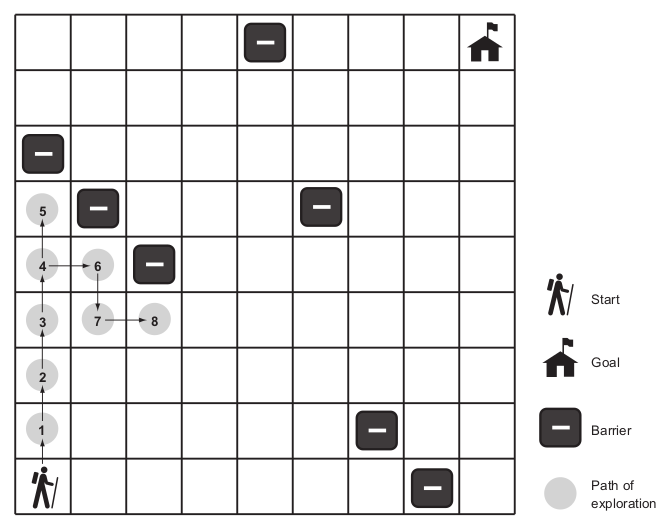

### Opdracht 4

Maak je eigen doolhof met een start- en eindvakje en verschillende barrières. Implementeer verschillende paden van start naar doel. Kan je een algoritme bedenken om altijd een pad van start naar doel te vinden zonder vast te lopen?